# Drive for Show; Putt for Dough

Below is the code where I aim to determine whether driving or putting ability is more important for professional golfers who's aim is to make the most money. The general premise is to create a machine learning regression model to predict per event earnings and then rank feature importance. The data comes from ESPN and reflects the earnings, outcomes, and playing statistics of the top 200 earners on the PGA tour in 2022.

## Import Libraries and Load Data

In [53]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pylab as plt
import xgboost as xg
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [54]:
df = pd.read_csv('C:\\Users\jense\PGA_Earnings_and_Player_Stats_2022.csv')
df = df.drop(df.columns[-1],axis=1)
df = df.dropna()

### EDA

In [55]:
df['EarnPerEvent'].describe()

count       200.000000
mean      87799.921100
std       97377.659397
min        8431.480000
25%       29670.155000
50%       52589.805000
75%      102830.462500
max      561876.400000
Name: EarnPerEvent, dtype: float64

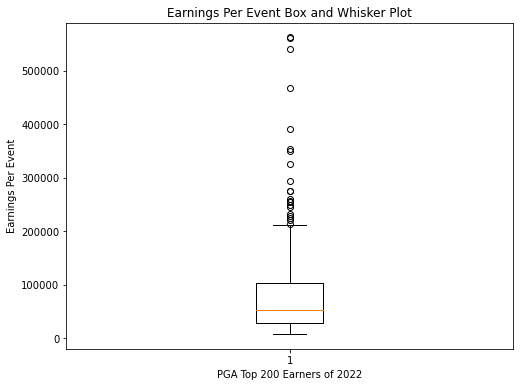

In [56]:
plt.figure(figsize = (8,6))
plt.boxplot(df['EarnPerEvent'])
plt.xlabel('PGA Top 200 Earners of 2022')
plt.ylabel('Earnings Per Event')
plt.title('Earnings Per Event Box and Whisker Plot')
plt.show()

In [67]:
print(df.corr())

                    RK  EarnPerEvent       CUP     EVNTS      RNDS      CUTS  \
RK            1.000000     -0.752401 -0.328413 -0.167903 -0.444721 -0.708358   
EarnPerEvent -0.752401      1.000000  0.042673 -0.178108  0.079119  0.372389   
CUP          -0.328413      0.042673  1.000000  0.148966  0.205882  0.250647   
EVNTS        -0.167903     -0.178108  0.148966  1.000000  0.870957  0.593747   
RNDS         -0.444721      0.079119  0.205882  0.870957  1.000000  0.809747   
CUTS         -0.708358      0.372389  0.250647  0.593747  0.809747  1.000000   
TOP10        -0.828028      0.846588  0.104225  0.068042  0.288720  0.538605   
WINS         -0.510188      0.800206 -0.143700 -0.066542  0.068496  0.246713   
SCORE        -0.289554      0.054928  0.138802  0.621580  0.839851  0.520506   
DDIS         -0.340184      0.111879  0.147151  0.606702  0.840168  0.545788   
DACC         -0.312306      0.066709  0.139923  0.594797  0.824514  0.546170   
GIR          -0.347982      0.121924  0.

## Train Test Split

In [57]:
#Define target variable and features
target = ['EarnPerEvent']

features = ['DDIS',
           'DACC',
           'GIR',
           'PUTTS',
           'SAND',
           'BIRDS',
           'WINS',
           'TOP10',
           'CUTS'
           ]

df_reduced = df[features + target]

#Initiate a qcut using q=4 to divide the data into quartiles based on the dependant variable for a stratified train test split
df_reduced['qcut'] = list(pd.qcut(df_reduced['EarnPerEvent'], 4, labels = False))

training_data, testing_data = train_test_split(df_reduced, test_size = .2, random_state = 42, stratify = df_reduced['qcut'])

X_train = training_data[features]
y_train = training_data[target]
X_test = testing_data[features]
y_test = testing_data[target]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Model Creation

### Untuned Model

In [59]:
xg_regressor =xg.XGBRegressor()
xg_model = xg_regressor.fit(X_train,y_train)

y_pred = xg_model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error on test set is: ", mse)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R squared score on test set is: ", r2)


Mean squared error on test set is:  3222627145.0248227
R squared score on test set is:  0.6887608434100394


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Hyperparameter Tuning w Grid Search

In [60]:
from sklearn.model_selection import GridSearchCV
params = {'eta': [0.2],
          'max_depth': [10,20,100],
          'reg_lambda': [1.3,1.4,1.5,1.6,1.7],
          'n_estimators': [100,200,500],
          }
reg = GridSearchCV(estimator = xg_regressor,
                  param_grid = params,
                  scoring = 'r2',
                  verbose = 0)
reg.fit(X_train,y_train)
print("Best parameters: ", reg.best_params_)
print("Best R2: ", reg.best_score_)

### Tuned Model

In [61]:
#Manually input best params into the regressor
xg_regressor_tuned =xg.XGBRegressor(n_estimators = 500, max_depth = 20, eta = 0.2, reg_lambda = 1.4)
xg_model_tuned = xg_regressor_tuned.fit(X_train,y_train)

y_pred_tuned = xg_model_tuned.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_tuned)
print("Mean squared error on test set is: ", mse)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_tuned)
print("R squared score on test set is: ", r2)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Mean squared error on test set is:  2321677595.292609
R squared score on test set is:  0.7757739433963858


In [62]:
# Uncomment if shap library is not installed
# pip install shap

## Feature Importance

## Shap Values

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


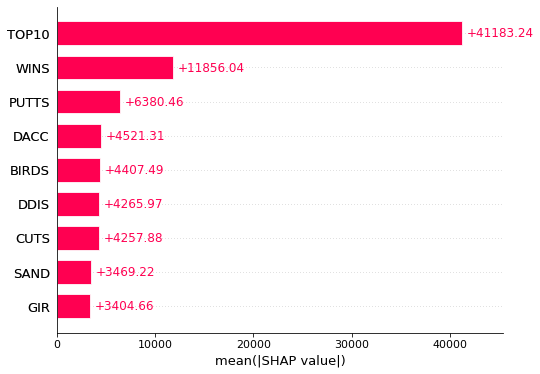

In [63]:
import shap
explainer = shap.Explainer(xg_model_tuned.predict,X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display = 10)

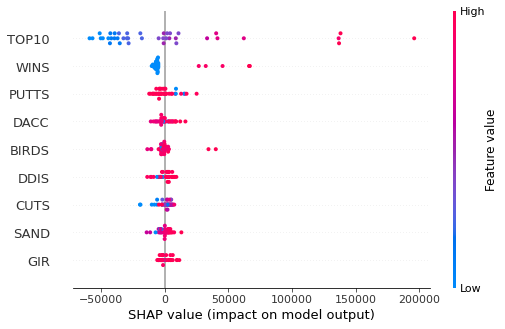

In [64]:
shap.plots.beeswarm(shap_values, max_display = 10)

## Gini Impurity

In [65]:
importance_scores = xg_model_tuned.feature_importances_
feature_importance = dict(zip(X_train.columns,importance_scores))
ranked_features = sorted(feature_importance,key = feature_importance.get, reverse = True)
print("Ranked features based on Gini: ", ranked_features)
print("Feature Importance based on Gini: ",feature_importance)

Ranked features based on Gini:  ['TOP10', 'WINS', 'BIRDS', 'PUTTS', 'CUTS', 'DACC', 'GIR', 'SAND', 'DDIS']
Feature Importance based on Gini:  {'DDIS': 0.0022308836, 'DACC': 0.0071968306, 'GIR': 0.0048345593, 'PUTTS': 0.011066812, 'SAND': 0.003900229, 'BIRDS': 0.0600625, 'WINS': 0.24036334, 'TOP10': 0.6627267, 'CUTS': 0.007618177}
